# Does the month ahead close for the S&P 500 finish ahead or behind?

### How well will our supervised learning models tackle this binary classification problem?

## Notebook Index

- `Part I, Imports`
 
- `Part II, Wrangle Data & EDA`
  
- `Part III, Split the Data`
    
- `Part IV, Establish a Baseline`

- `Part V, Build Models`
    `-`
   - `LogisticRegression`
   - `RandomForestClassifier` 
   - `RidgeClassifier`
   - `XGBoostClassifier`

- `Part VI, Check Metrics`
    `-`
   - `Models, Scores`
   - `Cross Validation & Tuning`
   - `Recheck Metrics`

- `Part VII, Examining Model Output`
   - `Confusion Matrices/Precision & Recall`
   - `ROC Curves`
   - `PDP Isloates/PDP Interact Objects/3D PDP Interact Objects`
   - `Shap Plots of Individual Observations`



# I. Imports

In [ ]:
# Inline package installations when working in Colab.
# Shap doesn't work with Python 3.9

import sys

if 'google.colab' in sys.modules:
    DATA_PATH = ''
    !pip install pdpbox
    !pip install shap

else:
    DATA_PATH = DATA_PATH = '../data/build_finance/'

In [ ]:
# Import files into Google Colab
from google.colab import files
files = files.upload()

In [ ]:
# Imports
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from scipy.stats import pearsonr
#from shap import Explainer, TreeExplainer, initjs, forceplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, XGBClassifier

In [ ]:
# Set viewing options
pd.set_option('display.max_rows', 150)
plt.rcParams['figure.dpi'] = 72

# II. Wrangle and Explore Data

In [ ]:
# Wrangle Data

def readIn(file, parse_d='DATE', idx='DATE'):
    """ Opens .csv file, creates datetime index, and returns DataFrame"""

    #DATA_PATH = '../data/build_finance/'
    # df = pd.read_csv(DATA_PATH+file,
    #                  parse_dates=[parse_d]).set_index(idx)
    df = pd.read_csv(file,
                     parse_dates=[parse_d]).set_index(idx)                 
    return df


def manyToOne(files_m, files_q, file_w):
    """Accepts lists of .csv files and returns single DataFrame"""

    # Takes monthly and quarterly files, has them read_in, parses their
    # dates, and return DataFrames held in lists
    frames_m = [readIn(file) for file in files_m]
    frames_q = [readIn(file) for file in files_q]

    # Reads in SP500 data, indicates columns to use, and capitalizes 'DATE'
    # for consistency with other DataFrames held in frames_m and frames_q
    # DATA_PATH = '../data/build_finance/'
    # sp = pd.read_csv(DATA_PATH+file_w, usecols=['Date', 'Close'],
    #                  parse_dates=['Date']).set_index('Date')
    sp = pd.read_csv(file_w, usecols=['Date', 'Close'],
                     parse_dates=['Date']).set_index('Date')                 
    sp.rename(columns={'Date': 'DATE', 'Close': 'SP500_CLOSE'}, inplace=True)

    # Concatenate DataFrames held in frames_m and frames_q
    concat_m = pd.concat(frames_m, axis=1)
    concat_q = pd.concat(frames_q, axis=1)

    # Final concatenation of all DataFrames (monthly data, quarterly data 
    # and SP500 data)
    last = pd.concat([concat_m, concat_q, sp], axis=1)

    # SP500 data is only available from 1/1/1985
    # Mask out dates prior to January 1st, 1985
    mask = last.index >= '1985-01-01'
    df_final = last[mask]
    df_final.shape

    # Return DataFrame
    return df_final


def wrangle(files_m, files_q, file_w):
    # Pass .csv files and have a single DataFrame returned
    df = manyToOne(files_m, files_q, file_w)

    # Rename columns
    df.columns = ['CPI', '10-year-T', 'Housing-Starts', 
                  'Industrial-Production', 'Initial-Claims', 'Unemployment-Rate', 
                  'Corporate-Profits', 'Exports-Goods-Services', 'GDP', 'Net-Exports',
                  'SP500-Close']
    
    # Reorganize columns
    df = df.reindex(columns=['10-year-T', 'Corporate-Profits', 'CPI', 
                        'Exports-Goods-Services', 'GDP', 'Housing-Starts', 
                        'Industrial-Production', 'Initial-Claims', 'Net-Exports',
                        'Unemployment-Rate', 'SP500-Close'])

    # Create a target feature, month-ahead-return: positive/negative - 
    # Binary Classification
    df['SP500-Ahead'] = df['SP500-Close'].shift(-1)
    df['SP500-PosNeg'] = (df['SP500-Close'].shift(-1) - df['SP500-Close']) > 0
    
    # Forward fill the quarterly data
    df.ffill(inplace=True)

    # Scale features     
    df['Initial-Claims'] = df['Initial-Claims'] / 1_000_000_000
    df['Housing-Starts'] = df['Housing-Starts'] / 1_000_000_000
    df['10-year-T'] = df['10-year-T'] / 100
    df['Unemployment-Rate'] = df['Unemployment-Rate'] / 100
    
    # Create new feature the shows the monthly change in monthly initial unemployment 
    # claims
    
    # df['init_claims_mo_unemployment_rate'] = 1 - (df['initial_claims'] / df['unemployment_rate'].shift(-1))
    # df['unemployment_rate_ma_housing_starts'] = 1 - (df['unemployment_rate'] / df['housing_starts'].shift(-1))
    # #df['change_housing_starts'] = 1 - (df['housing_starts'] / df['housing_starts'].shift(+1))

    # Drop 'initial_claims'
    # df.drop(columns='initial_claims')
    # df.drop(columns=['initial_claims', 'housing_starts'], inplace=True)

    # Return wrangled DataFrame
    return df


file_w = '^GSPC_m.csv'

files_m = ['CPI.csv',
           'DGS10.csv',
           'HOUST.csv',
           'INDPRO.csv',
           'INITCLMS.csv',
           'UNRATE.csv']

files_q = ['CP.csv',
           'EXPGS.csv',
           'GDP.csv',
           'NETEXP.csv',]

df = wrangle(files_m, files_q, file_w)
print(df.shape)
df.head(10)

(427, 13)


10-year-T  Corporate-Profits  ...  SP500-Ahead  SP500-PosNeg
1985-01-01   0.113843            204.768  ...   181.179993          True
1985-02-01   0.115089            204.768  ...   180.660004         False
1985-03-01   0.118552            204.768  ...   179.830002         False
1985-04-01   0.114348            205.850  ...   189.550003          True
1985-05-01   0.108468            205.850  ...   191.850006          True
1985-06-01   0.101560            205.850  ...   190.919998         False
1985-07-01   0.103068            209.890  ...   188.630005         False
1985-08-01   0.103318            209.890  ...   182.080002         False
1985-09-01   0.103732            209.890  ...   189.820007          True
1985-10-01   0.102368            211.649  ...   202.169998          True

[10 rows x 13 columns]

In [ ]:
# There are 10 feature variables in the dataset.
# 'SP500-Ahead' is our target; we are attempting to predict whether or not the
# next months closing price for the SP500 is ahead or behind the prior month.
# To address any potential for data leakage, we will refrain from creating 
# any new features using the target, we won't perform any fitting using our 
# validation sets, and we will watch for any significant declines in our 
# models' performance when scoring our test sets. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 1985-01-01 to 2020-07-01
Freq: MS
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   10-year-T               427 non-null    float64
 1   Corporate-Profits       427 non-null    float64
 2   CPI                     427 non-null    float64
 3   Exports-Goods-Services  427 non-null    float64
 4   GDP                     427 non-null    float64
 5   Housing-Starts          427 non-null    float64
 6   Industrial-Production   427 non-null    float64
 7   Initial-Claims          427 non-null    float64
 8   Net-Exports             427 non-null    float64
 9   Unemployment-Rate       427 non-null    float64
 10  SP500-Close             427 non-null    float64
 11  SP500-Ahead             427 non-null    float64
 12  SP500-PosNeg            427 non-null    bool   
dtypes: bool(1), float64(12)
memory usage: 43.8 KB




 Correlation coefficients and p values for Unemployment-Rate and SP500-Close:


correlation_coefficients       p_values
GDP                                     0.921455  1.278788e-176
CPI                                     0.904093  5.101689e-159
Exports-Goods-Services                  0.894028  2.712999e-150
Industrial-Production                   0.865456  1.189859e-129
Corporate-Profits                       0.860630  1.233172e-126
Initial-Claims                          0.079179   1.022762e-01
Housing-Starts                         -0.203200   2.328281e-05
Unemployment-Rate                      -0.264437   2.900099e-08
Net-Exports                            -0.712323   2.443694e-67
10-year-T                              -0.822998  1.922726e-106



 Heatmap correlation betwen features and SP500-Close:


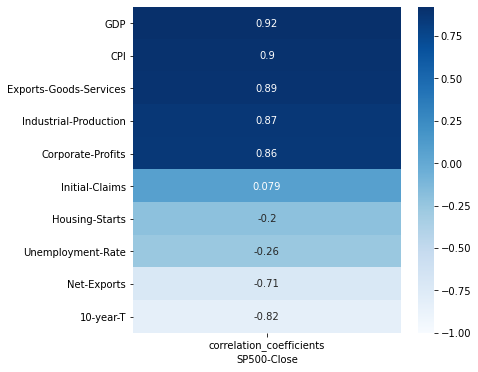



 Correlation coefficients and p values for Unemployment-Rate and SP500-Ahead:


correlation_coefficients       p_values
GDP                                     0.919745  1.032061e-174
CPI                                     0.903142  3.742913e-158
Exports-Goods-Services                  0.892684  3.403643e-149
Industrial-Production                   0.862061  1.616850e-127
Corporate-Profits                       0.861654  2.887023e-127
Initial-Claims                          0.095374   4.889350e-02
Housing-Starts                         -0.205111   1.941791e-05
Unemployment-Rate                      -0.256145   7.994356e-08
Net-Exports                            -0.707526   4.553945e-66
10-year-T                              -0.824242  4.957091e-107



 Heatmap correlation betwen features and SP500-Ahead:


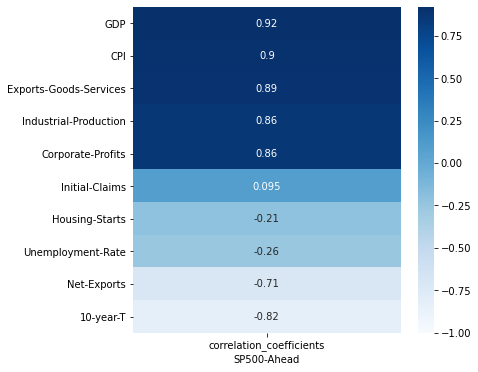

In [ ]:
# Let's examine the correlations between the SP500 closing prices and the features
# Initial claims, housing starts, and unemployment rates appear weakly, or very 
# weakly correlated.

# Examining the correlations between the month ahead SP500 closing prices and the 
# features presents largely in the same manner. 

# Will explore model performance without these features
# Will also try creating new features with these variables to see if they change 
# correlations at all. 

feature_cols = list(df.columns[:-3])
target_cols = list(df.columns[-3:-1])

for entry in target_cols:
    corr_coefs = []
    p_vals = []
    for column in feature_cols:
        corrcoef = pearsonr(df[column], df[entry])[0]
        pval = pearsonr(df[column], df[entry])[1]
        corr_coefs.append(corrcoef)
        p_vals.append(pval)

    print(f'\n\n Correlation coefficients and p values for {column} and {entry}:')       
    
    corrs_sp500_close = pd.DataFrame({'correlation_coefficients': corr_coefs, 
                                      'p_values': p_vals}, 
                                       index=feature_cols)
    
    corrs_sp500_close.sort_values(by='correlation_coefficients', 
                                  ascending=False, 
                                  inplace=True)
    display(corrs_sp500_close)

    print(f'\n\n Heatmap correlation betwen features and {entry}:')       
    plt.figure(figsize=(6,6))
    sns.heatmap(corrs_sp500_close[['correlation_coefficients']],
            vmin=-1,
            cmap='Blues',
            annot=True);
    plt.xlabel(entry)  
    plt.show();



 Correlation coefficients and p values for 10-year-T and remaining features:


correlation_coefficients       p_values
Net-Exports                             0.771881   1.261427e-85
Housing-Starts                          0.399477   8.630850e-18
Unemployment-Rate                      -0.068746   1.561690e-01
Initial-Claims                         -0.124321   1.012827e-02
Industrial-Production                  -0.887897  2.128729e-145
Corporate-Profits                      -0.889329  1.624797e-146
Exports-Goods-Services                 -0.907591  2.797363e-162
GDP                                    -0.935007  1.863311e-193
CPI                                    -0.948881  5.792701e-215



 Heatmap correlation betwen features and 10-year-T:


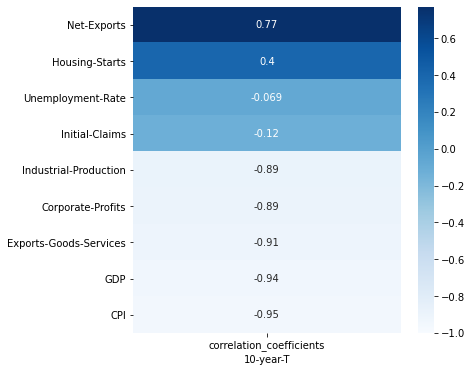



 Correlation coefficients and p values for Corporate-Profits and remaining features:


correlation_coefficients       p_values
Exports-Goods-Services                  0.975039  6.722974e-280
CPI                                     0.960145  2.083645e-237
GDP                                     0.951300  2.531396e-219
Industrial-Production                   0.865097  2.013637e-129
Unemployment-Rate                       0.031120   5.213028e-01
Initial-Claims                          0.024624   6.118621e-01
Housing-Starts                         -0.437317   2.256678e-21
Net-Exports                            -0.819896  5.391396e-105
10-year-T                              -0.889329  1.624797e-146



 Heatmap correlation betwen features and Corporate-Profits:


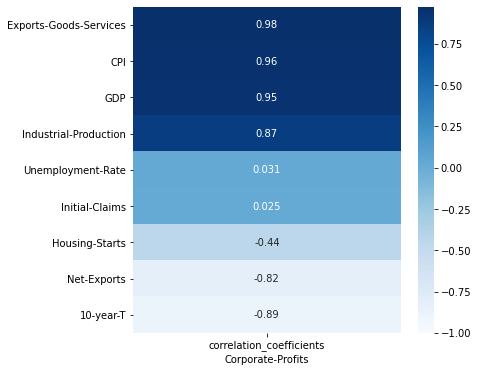



 Correlation coefficients and p values for CPI and remaining features:


correlation_coefficients       p_values
GDP                                     0.991340   0.000000e+00
Exports-Goods-Services                  0.977807  1.276045e-290
Corporate-Profits                       0.960145  2.083645e-237
Industrial-Production                   0.932133  1.344893e-189
Initial-Claims                          0.084949   7.953341e-02
Unemployment-Rate                      -0.013828   7.757033e-01
Housing-Starts                         -0.432088   7.514332e-21
Net-Exports                            -0.825722  9.751255e-108
10-year-T                              -0.948881  5.792701e-215



 Heatmap correlation betwen features and CPI:


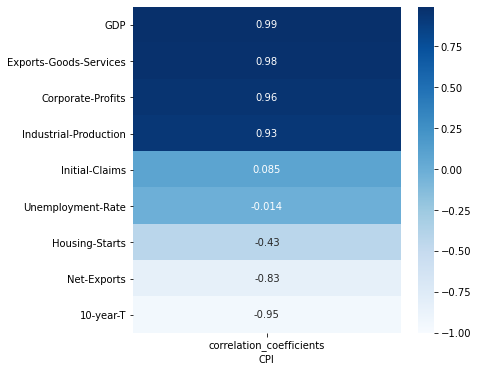



 Correlation coefficients and p values for Exports-Goods-Services and remaining features:


correlation_coefficients       p_values
CPI                                    0.977807  1.276045e-290
Corporate-Profits                      0.975039  6.722974e-280
GDP                                    0.965283  6.614264e-250
Industrial-Production                  0.888053  1.609711e-145
Initial-Claims                         0.002062   9.661162e-01
Unemployment-Rate                     -0.028802   5.528227e-01
Housing-Starts                        -0.494099   1.148496e-27
Net-Exports                           -0.780060   1.417882e-88
10-year-T                             -0.907591  2.797363e-162



 Heatmap correlation betwen features and Exports-Goods-Services:


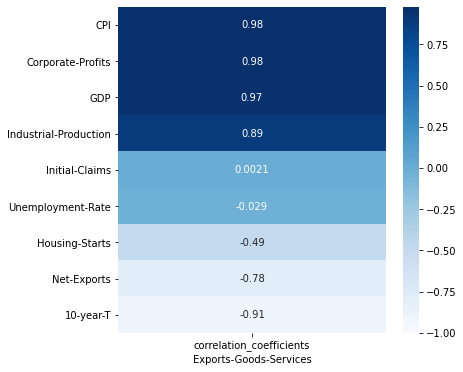



 Correlation coefficients and p values for GDP and remaining features:


correlation_coefficients       p_values
CPI                                     0.991340   0.000000e+00
Exports-Goods-Services                  0.965283  6.614264e-250
Industrial-Production                   0.957736  4.197469e-232
Corporate-Profits                       0.951300  2.531396e-219
Initial-Claims                          0.042565   3.802812e-01
Unemployment-Rate                      -0.105077   2.993517e-02
Housing-Starts                         -0.339064   6.009633e-13
Net-Exports                            -0.864446  5.197802e-129
10-year-T                              -0.935007  1.863311e-193



 Heatmap correlation betwen features and GDP:


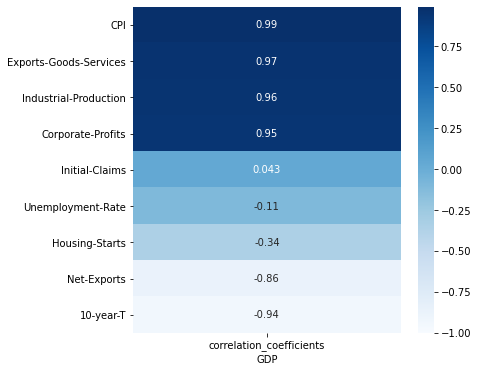



 Correlation coefficients and p values for Housing-Starts and remaining features:


correlation_coefficients      p_values
10-year-T                               0.399477  8.630850e-18
Net-Exports                             0.113403  1.907508e-02
Initial-Claims                         -0.140103  3.720601e-03
Industrial-Production                  -0.193091  5.914863e-05
GDP                                    -0.339064  6.009633e-13
CPI                                    -0.432088  7.514332e-21
Corporate-Profits                      -0.437317  2.256678e-21
Exports-Goods-Services                 -0.494099  1.148496e-27
Unemployment-Rate                      -0.535792  4.246492e-33



 Heatmap correlation betwen features and Housing-Starts:


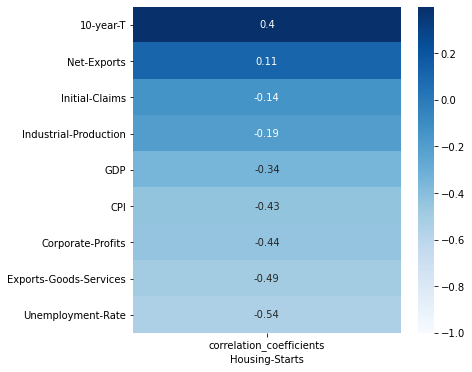



 Correlation coefficients and p values for Industrial-Production and remaining features:


correlation_coefficients       p_values
GDP                                     0.957736  4.197469e-232
CPI                                     0.932133  1.344893e-189
Exports-Goods-Services                  0.888053  1.609711e-145
Corporate-Profits                       0.865097  2.013637e-129
Initial-Claims                         -0.033669   4.877542e-01
Housing-Starts                         -0.193091   5.914863e-05
Unemployment-Rate                      -0.234975   9.098657e-07
Net-Exports                            -0.883844  2.567850e-142
10-year-T                              -0.887897  2.128729e-145



 Heatmap correlation betwen features and Industrial-Production:


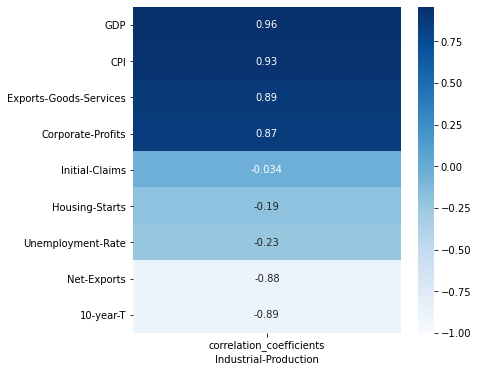



 Correlation coefficients and p values for Initial-Claims and remaining features:


correlation_coefficients      p_values
Unemployment-Rate                       0.484518  1.607620e-26
CPI                                     0.084949  7.953341e-02
GDP                                     0.042565  3.802812e-01
Corporate-Profits                       0.024624  6.118621e-01
Exports-Goods-Services                  0.002062  9.661162e-01
Net-Exports                            -0.021835  6.527590e-01
Industrial-Production                  -0.033669  4.877542e-01
10-year-T                              -0.124321  1.012827e-02
Housing-Starts                         -0.140103  3.720601e-03



 Heatmap correlation betwen features and Initial-Claims:


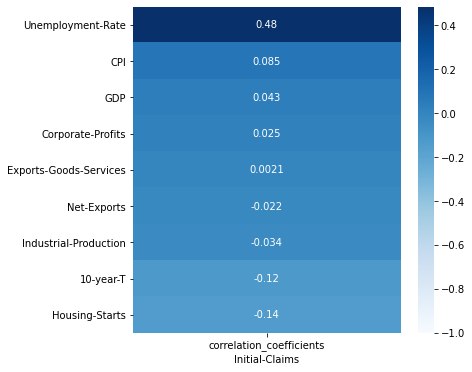



 Correlation coefficients and p values for Net-Exports and remaining features:


correlation_coefficients       p_values
10-year-T                               0.771881   1.261427e-85
Housing-Starts                          0.113403   1.907508e-02
Unemployment-Rate                       0.087264   7.164283e-02
Initial-Claims                         -0.021835   6.527590e-01
Exports-Goods-Services                 -0.780060   1.417882e-88
Corporate-Profits                      -0.819896  5.391396e-105
CPI                                    -0.825722  9.751255e-108
GDP                                    -0.864446  5.197802e-129
Industrial-Production                  -0.883844  2.567850e-142



 Heatmap correlation betwen features and Net-Exports:


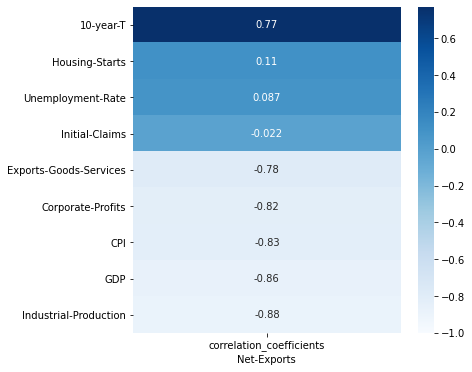



 Correlation coefficients and p values for Unemployment-Rate and remaining features:


correlation_coefficients      p_values
Initial-Claims                          0.484518  1.607620e-26
Net-Exports                             0.087264  7.164283e-02
Corporate-Profits                       0.031120  5.213028e-01
CPI                                    -0.013828  7.757033e-01
Exports-Goods-Services                 -0.028802  5.528227e-01
10-year-T                              -0.068746  1.561690e-01
GDP                                    -0.105077  2.993517e-02
Industrial-Production                  -0.234975  9.098657e-07
Housing-Starts                         -0.535792  4.246492e-33



 Heatmap correlation betwen features and Unemployment-Rate:


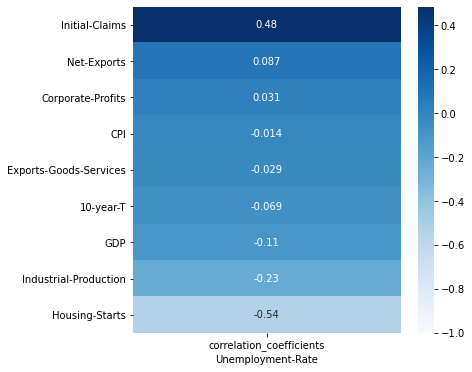

In [ ]:
# Let's examine the correlations of the features to each other 
# There appears to be a lot of multcollinearity - our models may not 
# give valid results about any individual predictor, or about which 
# predictors are redundant with respect to others

feature_cols = list(df.columns[:-3])
target_cols = list(df.columns[-3:-1])


for column in feature_cols:
    corr_coefs = []
    p_vals = []
    features = feature_cols.copy()
    features.remove(column)

    for feature in features:
        corrcoef = pearsonr(df[column], df[feature])[0]
        pval = pearsonr(df[column], df[feature])[1]
        corr_coefs.append(corrcoef)
        p_vals.append(pval)

    print(f'\n\n Correlation coefficients and p values for {column} and remaining features:')       
    corrs = pd.DataFrame({'correlation_coefficients': corr_coefs, 
                                    'p_values': p_vals}, index=features)
    corrs.sort_values(by='correlation_coefficients', ascending=False, inplace=True)
    display(corrs)

    print(f'\n\n Heatmap correlation betwen features and {column}:')       
    plt.figure(figsize=(6,6))
    sns.heatmap(corrs[['correlation_coefficients']],
            vmin=-1,
            cmap='Blues',
            annot=True)
    plt.xlabel(column)
    plt.show();

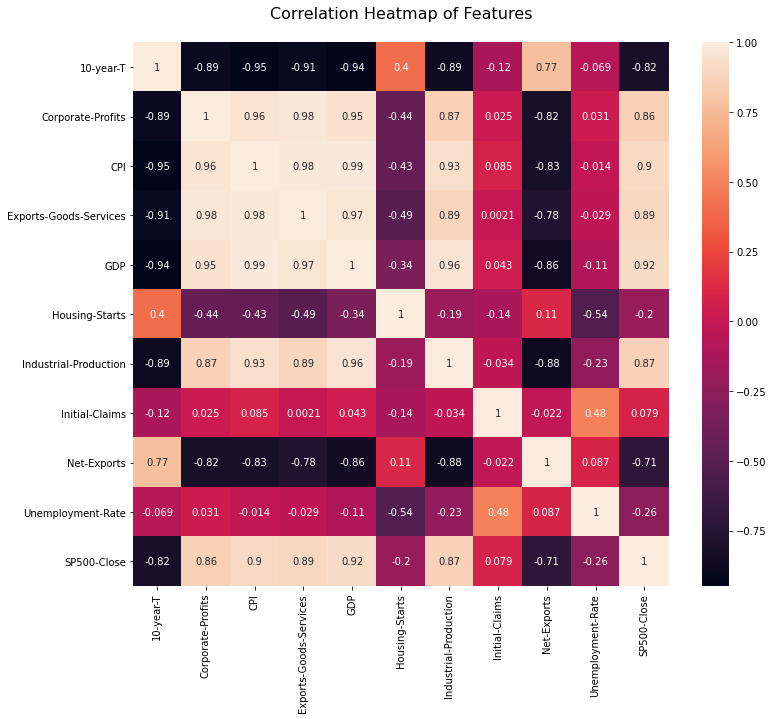

In [ ]:
# Correlation heatmap of features
# There are high correlations amongst the variables 
# Exceptions include 'Unemployment-Rate', 'Housing-Starts', and 
# 'Initial-Claims'

df_features = df.drop(columns=['SP500-Ahead', 'SP500-PosNeg'])

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(df_features.corr(), annot = True);
plt.title('Correlation Heatmap of Features', fontsize=16, pad=24);

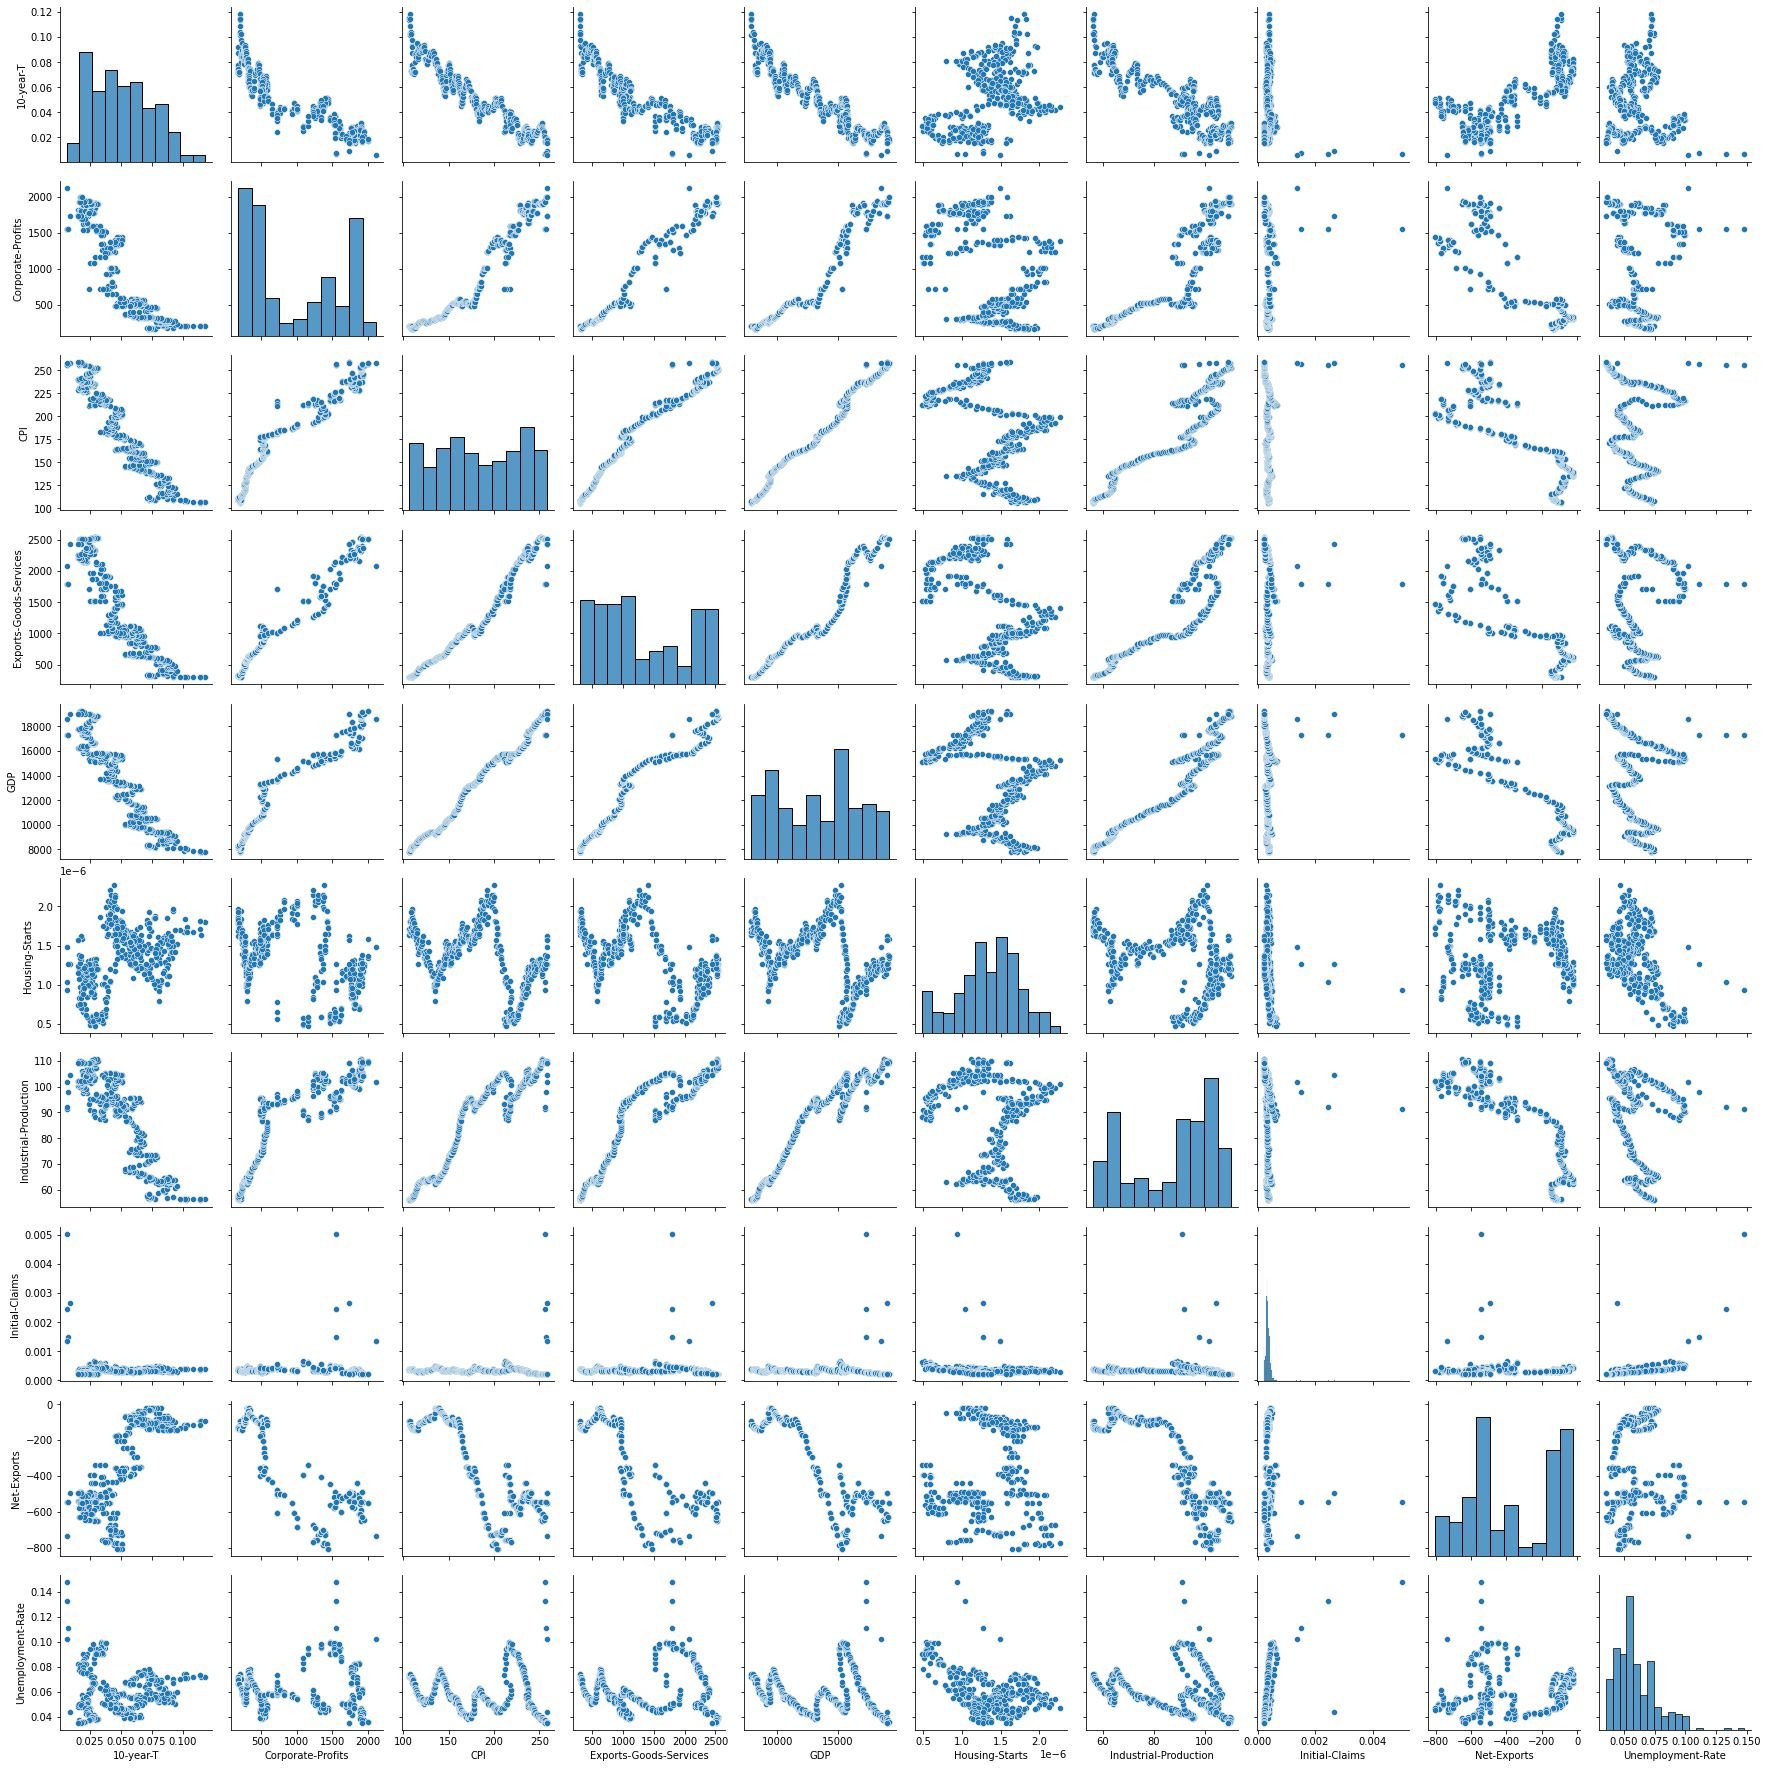

In [ ]:
sns.pairplot(df[['10-year-T', 'Corporate-Profits', 'CPI', 
                        'Exports-Goods-Services', 'GDP', 'Housing-Starts', 
                        'Industrial-Production', 'Initial-Claims', 'Net-Exports',
                        'Unemployment-Rate']])
plt.show()

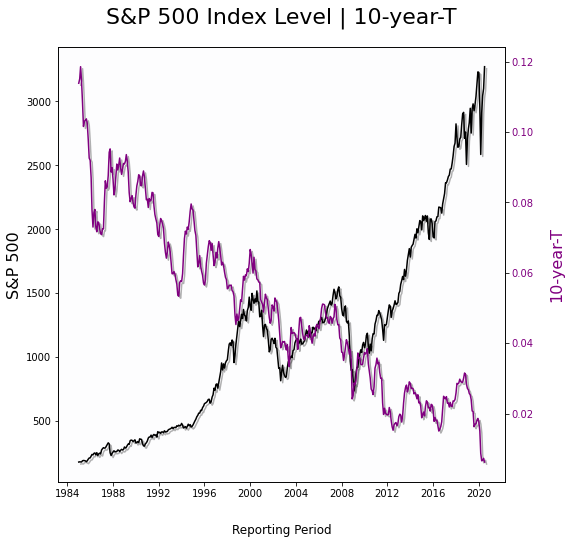

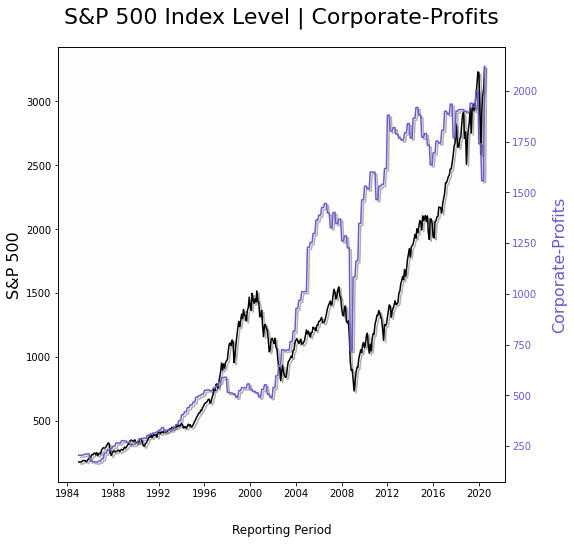

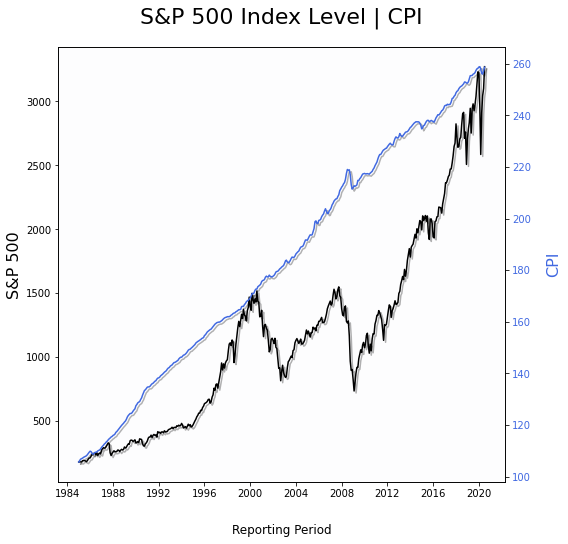

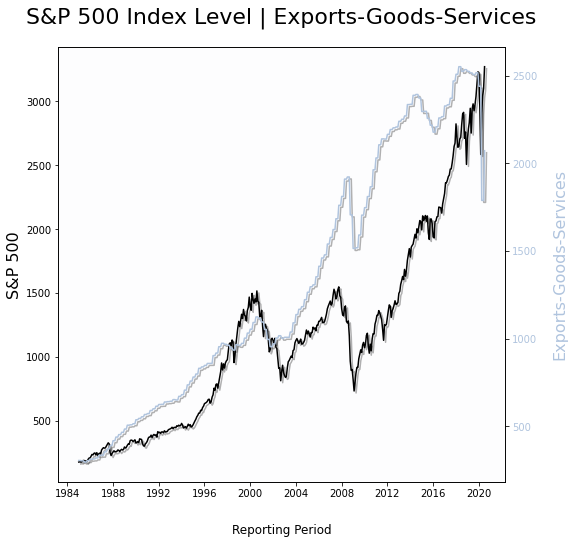

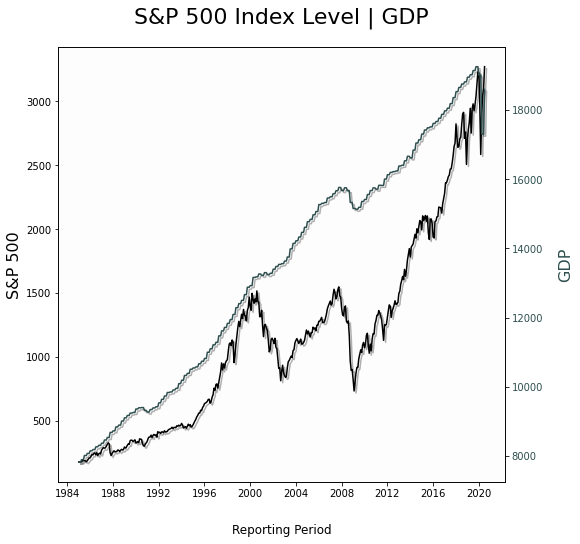

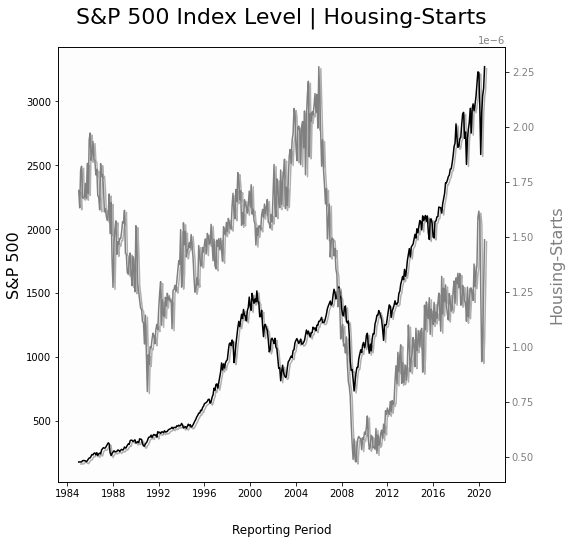

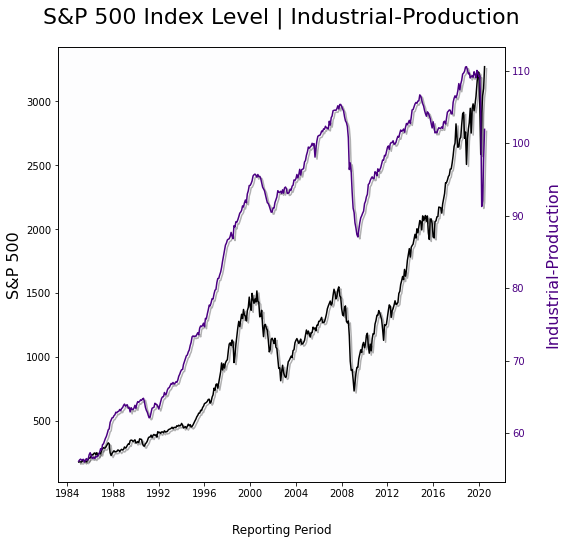

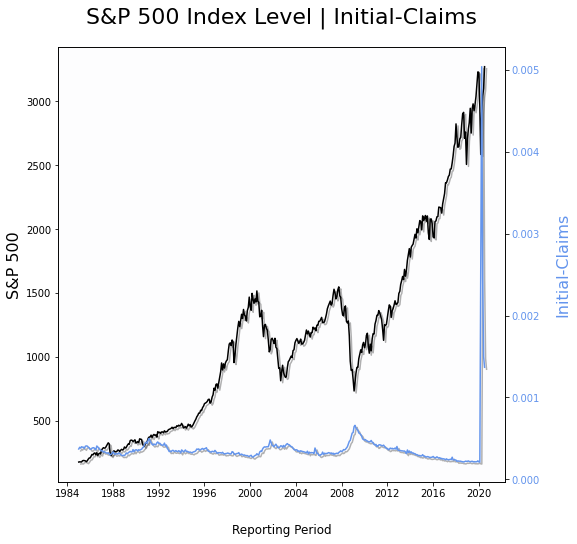

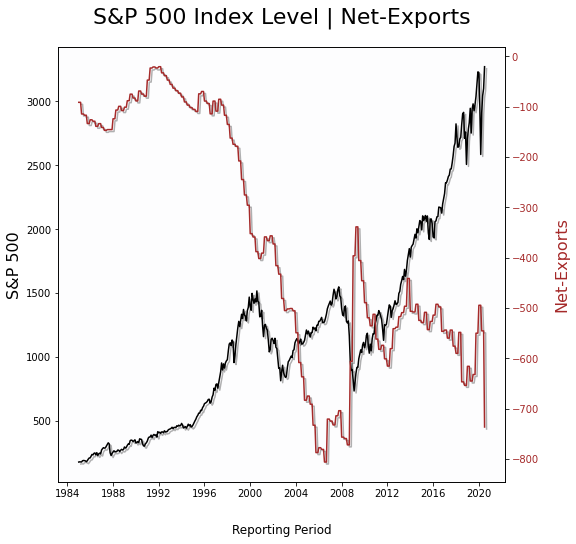

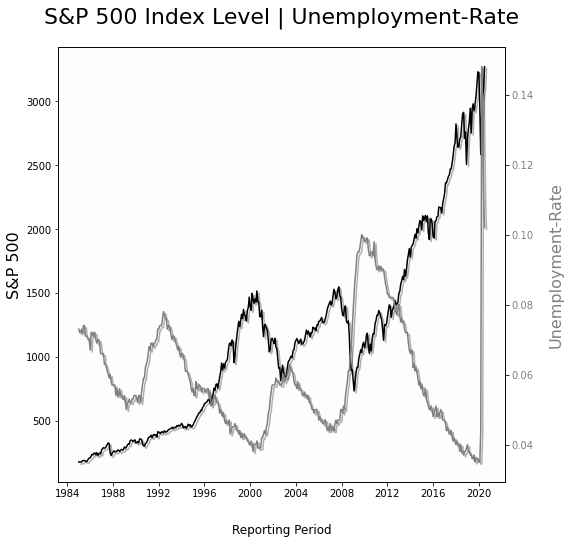

In [ ]:
# SP500 plot versus features.
# Non-monotonic data

feature_cols = list(df.columns[:-3])

color = ['purple', 'slateblue', 'royalblue', 'lightsteelblue', 'darkslategrey', 
         'grey', 'indigo', 'cornflowerblue', 'brown', 'grey']

for num, column in enumerate(feature_cols):
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.set_facecolor('xkcd:pale grey')
    ax.set_title(f'S&P 500 Index Level | {column}',
                 fontsize=22, pad=24)

    ax.set_xlabel('Reporting Period', fontsize=12, labelpad=25)

    ax.plot(df.index, df['SP500-Close'], color='black', path_effects=
                        [path_effects.SimpleLineShadow(), path_effects.Normal()])
    ax.set_ylabel('S&P 500', verticalalignment='bottom', fontsize=16) 
    ax.tick_params(axis='y')

    ax2 = ax.twinx()

    ax2.plot(df.index, df[column], color=color[num],
            path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
    ax2.set_ylabel(column, color=color[num], verticalalignment='top', 
                fontsize=16, labelpad=15)
    ax2.tick_params(axis='y', labelcolor=color[num])

    plt.show()



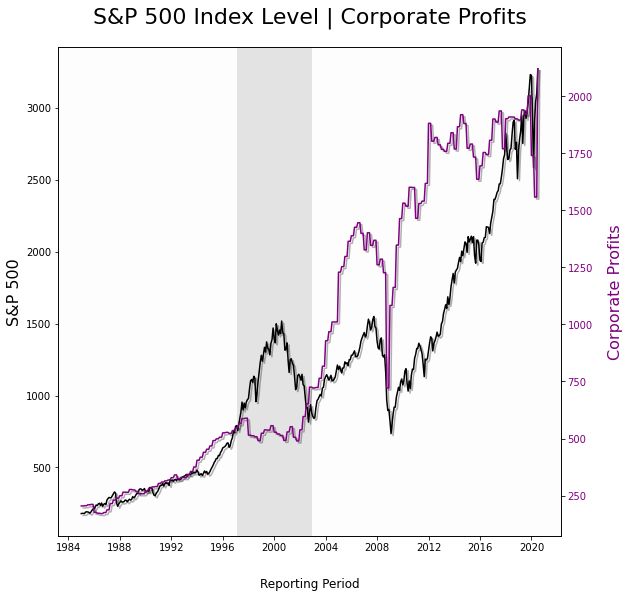

In [ ]:
# SP500 versus Corporate Profits with interesting chart 
# findings highlighted

fig, ax = plt.subplots(figsize=(9, 9))

ax.set_facecolor('xkcd:pale grey')
ax.set_title('S&P 500 Index Level | Corporate Profits',
     
             fontsize=22, pad=24)

ax.set_xlabel('Reporting Period', fontsize=12, labelpad=25)

ax.plot(df.index, df['SP500-Close'], color='black', path_effects=
                    [path_effects.SimpleLineShadow(), path_effects.Normal()])
ax.set_ylabel('S&P 500', verticalalignment='bottom', fontsize=16) 
ax.tick_params(axis='y')

ax2 = ax.twinx()

ax2.plot(df.index, df['Corporate-Profits'], color='purple',
          path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
ax2.set_ylabel('Corporate Profits', color='purple', verticalalignment='top', 
               fontsize=16, labelpad=15)
ax2.tick_params(axis='y', labelcolor='purple')

ax.axvline(x=df.index[180], linewidth=75, color=(0,0,0,0.1))

plt.show()


Distribution of 10-year-Treasury:


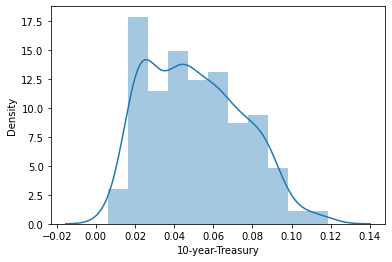



 10-year-Treasury with no transformation versus SP500 ahead




 Natural log distribution of 10-year-Treasury


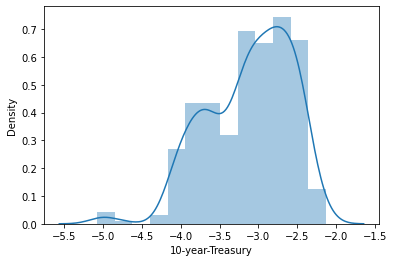



 10-year-Treasury with natural log transformation versus SP500 ahead


Distribution of Corporate-Profits:


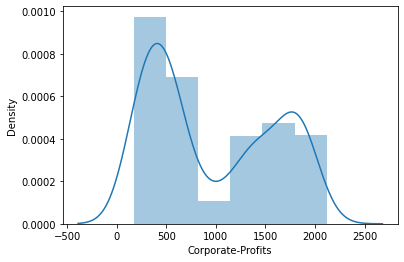



 Corporate-Profits with no transformation versus SP500 ahead




 Natural log distribution of Corporate-Profits


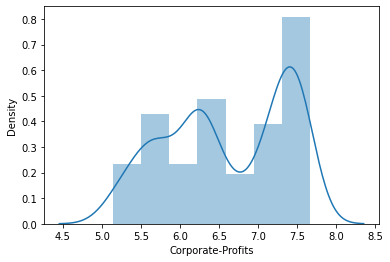



 Corporate-Profits with natural log transformation versus SP500 ahead


Distribution of CPI:


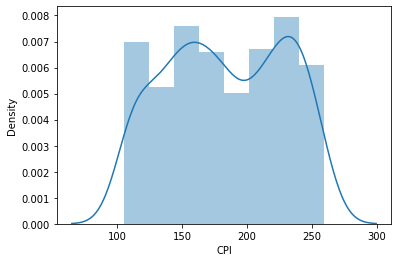



 CPI with no transformation versus SP500 ahead




 Natural log distribution of CPI


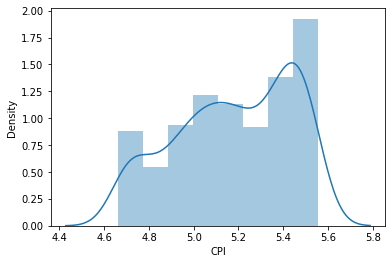



 CPI with natural log transformation versus SP500 ahead


Distribution of Exports-Goods-Services:


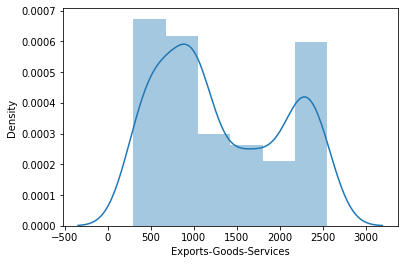



 Exports-Goods-Services with no transformation versus SP500 ahead




 Natural log distribution of Exports-Goods-Services


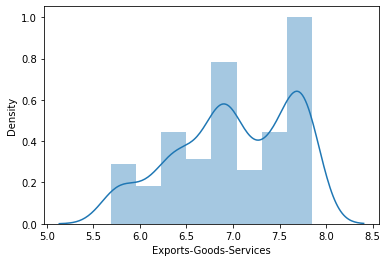



 Exports-Goods-Services with natural log transformation versus SP500 ahead


Distribution of GDP:


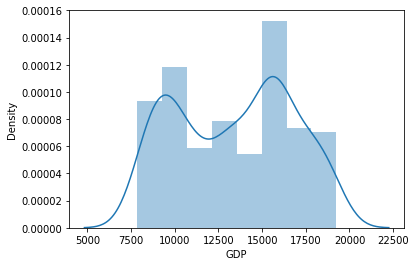



 GDP with no transformation versus SP500 ahead




 Natural log distribution of GDP


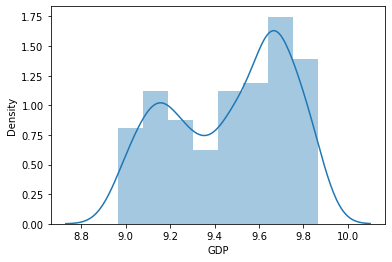



 GDP with natural log transformation versus SP500 ahead


Distribution of Housing-Starts:


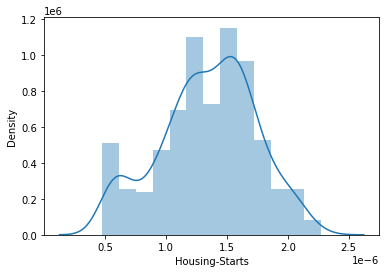



 Housing-Starts with no transformation versus SP500 ahead




 Natural log distribution of Housing-Starts


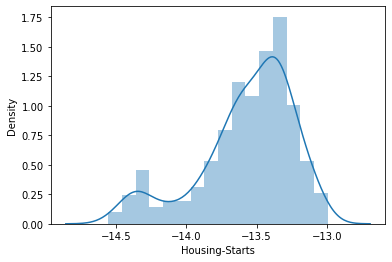



 Housing-Starts with natural log transformation versus SP500 ahead


Distribution of Industrial-Production:


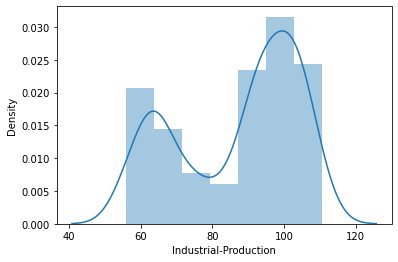



 Industrial-Production with no transformation versus SP500 ahead




 Natural log distribution of Industrial-Production


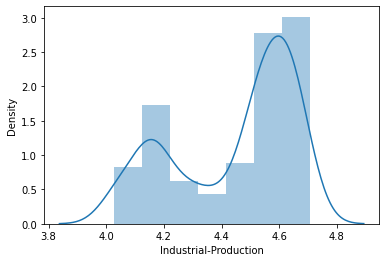



 Industrial-Production with natural log transformation versus SP500 ahead


Distribution of Initial-Claims:


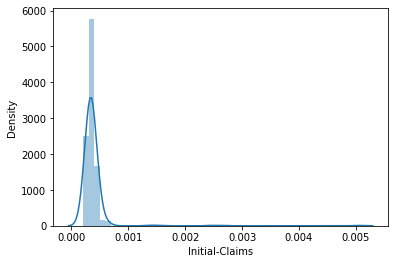



 Initial-Claims with no transformation versus SP500 ahead




 Natural log distribution of Initial-Claims


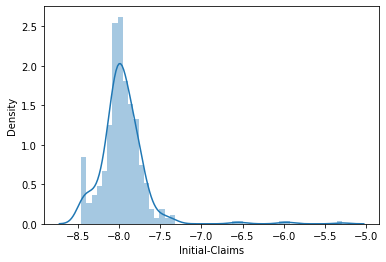



 Initial-Claims with natural log transformation versus SP500 ahead


Distribution of Net-Exports:


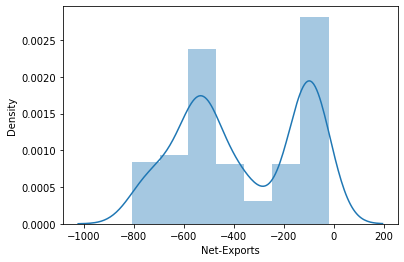



 Net-Exports with no transformation versus SP500 ahead




 Natural log distribution of Net-Exports


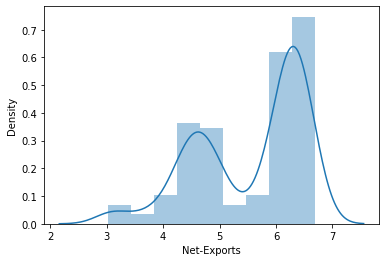



 Net-Exports with natural log transformation versus SP500 ahead


Distribution of Unemployment-Rate:


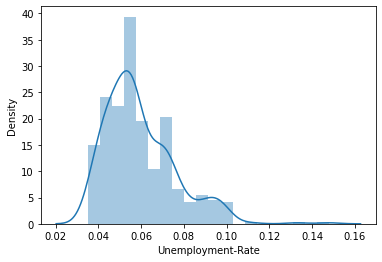



 Unemployment-Rate with no transformation versus SP500 ahead




 Natural log distribution of Unemployment-Rate


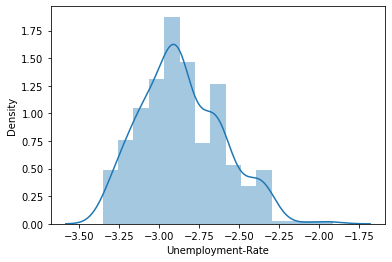



 Unemployment-Rate with natural log transformation versus SP500 ahead


In [ ]:
# Plot the individual feature distributions as a histogram
# Plot individual features vs SP500-ahead in a ols scatterplot
# Plot histogram distribution for natural log of feature
# Plot np.log of feature vs SP500-ahead in ols scatterplot

columns = list(df.columns[:-3])

for col in columns:
    print(f'Distribution of {col}:')
    sns.distplot(df[col])
    plt.show();

    print(f'\n\n {col} with no transformation versus SP500 ahead')
    display(px.scatter(df, x=col, y='SP500-Ahead', trendline='ols'))
    
    print(f'\n\n Natural log distribution of {col}')
    sns.distplot(np.log(abs(df[col])))
    plt.show();
    
    print(f'\n\n {col} with natural log transformation versus SP500 ahead')
    display(px.scatter(df, x=np.log(abs(df[col])), y='SP500-Ahead', trendline='ols'))
    

## Summary of Initial EDA

In [ ]:
# Dataset is comprised of continuous variables with a binary target variable -
# next month's close for the SP500 up or down?
# 'Housing-Starts', 'Initial-Claims' and 'Unemployment-Rate' do not appear to 
# show strong correlation with the SP500.
# There appears to be multicolinearity with the other variables not named above.

# III. Split the Data

In [ ]:
# Create a Feature Matrix and Target Vector
target = 'SP500-PosNeg'

y = df[target]
X = df.drop(columns=['SP500-Close', 'SP500-Ahead', 'SP500-PosNeg'])
print(X.shape, y.shape)
X.head()

(427, 10) (427,)


10-year-T  Corporate-Profits  ...  Net-Exports  Unemployment-Rate
1985-01-01   0.113843            204.768  ...      -91.298              0.073
1985-02-01   0.115089            204.768  ...      -91.298              0.072
1985-03-01   0.118552            204.768  ...      -91.298              0.072
1985-04-01   0.114348            205.850  ...     -114.445              0.073
1985-05-01   0.108468            205.850  ...     -114.445              0.072

[5 rows x 10 columns]

In [ ]:
# Split the data = create train and test sets 
# Will use 5-fold cross-validation with our training set
mask = df.index < '2014-01-01'

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(348, 10) (348,)
(79, 10) (79,)


# IV. Establish a Baseline

In [ ]:
# Let's look at the distribution of the target variable, 'SP500-PosNeg', and determine our 
# majority class - the market has been up in the month ahead about 62.93% of the time.
# There is no gross overweighting of our classes, and we can use accuracy score to assess.
# We will also explore precision/recall and ROC-AUC curves for multiple models. 

baseline_outcomes = y_train.value_counts(normalize=True)*100
print(f'The majority class is True - "The Market Went Up"')
print(f'Our basline accuracy score is {baseline_outcomes[1]:.2f}%')

The majority class is True - "The Market Went Up"
Our basline accuracy score is 62.93%


# V. Build Models

- `LogisticRegression`
 
- `RandomForrestClassifier`

- `RidgeClassifier`
    
- `XGBClassifier`

# +

# VI. Check Metrics

   - `Models, Scores`
   - `Cross Validation & Tuning`
   - `Recheck Metrics`

## Logistic Regression

In [ ]:
# Logistic Regression 
model_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
model_lr.score(X_train, y_train)

0.6494252873563219

In [ ]:
# Let's look at some interesting hyperparameters and tune the Logistic Regression model
estimator = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=22),
)

params = {'logisticregression__C': range(1, 21, 5),
          'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'logisticregression__max_iter': range(10, 201, 10)}

model_rs_lr = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    cv=5,
    verbose=10
)

model_rs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1782s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0559s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1187s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1370s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 500 o

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('standardscaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('logisticregression',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                

In [ ]:
model_rs_lr.best_params_

{'logisticregression__C': 11,
 'logisticregression__max_iter': 70,
 'logisticregression__solver': 'liblinear'}

In [ ]:
# Model performance is not significantly improved on the training set
model_rs_lr.best_score_

0.6439337474120083

In [ ]:
# Model performance was not significantly improved on the test data
model_rs_lr.score(X_test, y_test)

0.6835443037974683

## Random Forest Classifier

In [ ]:
# Random Forest Classifier 
model_rf = RandomForestClassifier(random_state=22)

model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [ ]:
model_rf.score(X_train, y_train)

1.0

In [ ]:
# Let's tune the model and see if we can help with 
# the overfitting

samples = np.arange(0.2, 1, 0.1)

train_acc = []
test_acc = []

for sample in samples:
    tree_model = RandomForestClassifier(
                    n_estimators=100,
                    n_jobs=-1,
                    random_state=22,
                    max_samples=sample)
    
    tree_model.fit(X_train, y_train)
    train_acc.append(tree_model.score(X_train, y_train))
    test_acc.append(tree_model.score(X_test, y_test))

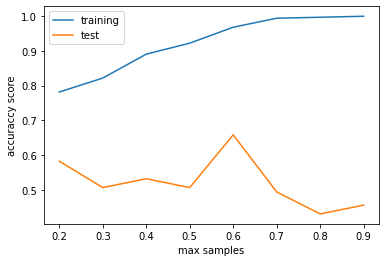

In [ ]:
plt.plot(samples, train_acc, label='training')
plt.plot(samples, test_acc, label='test')
plt.xlabel('max samples')
plt.ylabel('accuraccy score')
plt.legend();

In [ ]:
depths = np.arange(5, 46, 3)

train_acc = []
test_acc = []

for depth in depths:
    tree_model = RandomForestClassifier(
                    n_estimators=100,
                    n_jobs=-1,
                    random_state=22,
                    max_samples=0.6,
                    max_depth=depth
    )
    
    tree_model.fit(X_train, y_train)
    train_acc.append(tree_model.score(X_train, y_train))
    test_acc.append(tree_model.score(X_test, y_test))

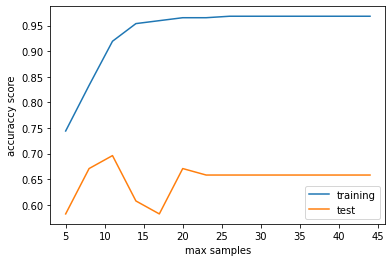

In [ ]:
plt.plot(depths, train_acc, label='training')
plt.plot(depths, test_acc, label='test')
plt.xlabel('max samples')
plt.ylabel('accuraccy score')
plt.legend();

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_samples=0.6,
    max_depth=12,
    random_state=22)

model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [ ]:
model_rf.score(X_train, y_train)

0.9252873563218391

In [ ]:
model_rf.score(X_test, y_test)

0.6708860759493671

## Ridge Classifier

In [ ]:
# Ridge Classifier

model_rc = make_pipeline(
    StandardScaler(),
    RidgeClassifier(random_state=22)
)

model_rc.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridgeclassifier',
                 RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True,
                                 fit_intercept=True, max_iter=None,
                                 normalize=False, random_state=22,
                                 solver='auto', tol=0.001))],
         verbose=False)

In [ ]:
model_rc.score(X_train, y_train)

0.6551724137931034

In [ ]:
coefficients = model_rc.named_steps['ridgeclassifier'].coef_
feature_names = X_train.columns

feature_importances = pd.Series(coefficients[0], index=feature_names)
feature_importances

10-year-T                -0.218797
Corporate-Profits         0.792410
CPI                       0.149443
Exports-Goods-Services   -0.330985
GDP                      -0.275009
Housing-Starts            0.161547
Industrial-Production    -0.171130
Initial-Claims            0.130481
Net-Exports               0.341377
Unemployment-Rate        -0.177108
dtype: float64

Text(0.5, 1.0, 'Feature Coefficients for Ridge Classifier model')

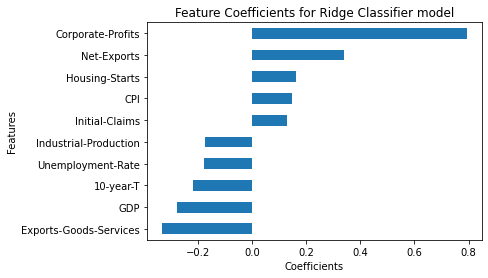

In [ ]:
feature_importances.sort_values().plot(kind='barh')
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Feature Coefficients for Ridge Classifier model')

In [ ]:
# Let's look at some interesting hyperparameters and tune the Ridge Classifier model

estimator = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RidgeClassifier(random_state=22),
)

params = {'ridgeclassifier__alpha': range(1, 102, 10)}

model_gs_rc = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_gs_rc.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('ridgeclassifier',
                                        RidgeClassifier(alpha=1.0,
                                              

In [ ]:
model_gs_rc.best_params_

{'ridgeclassifier__alpha': 1}

In [ ]:
model_gs_rc.best_score_

0.62351966873706

In [ ]:
model_gs_rc.score(X_test, y_test)

0.6835443037974683

## XGBoost Classifier

In [ ]:
# XGBoost Classifier

model_XGBC = XGBClassifier(
    max_depth=8, 
    learning_rate=0.01, 
    n_estimators=50, 
    colsample_bytree=0.1,
    n_jobs=-1, 
    random_state=22)

model_XGBC.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=22,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
model_XGBC.score(X_train, y_train)

0.7931034482758621

In [ ]:
model_XGBC.score(X_test, y_test)

0.6835443037974683

# VII. Further Examination of Models Outputs

Confusion matrices, train & test data, model used - Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)





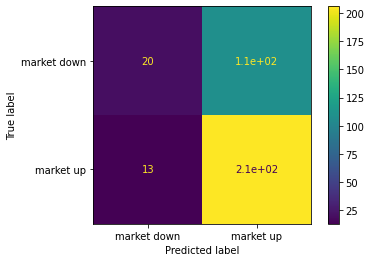

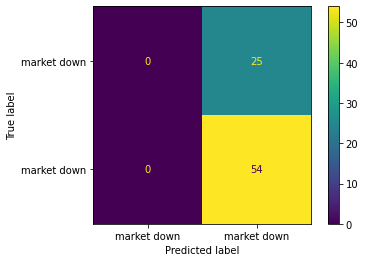

Confusion matrices, train & test data, model used - RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)





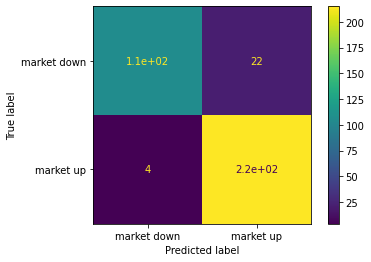

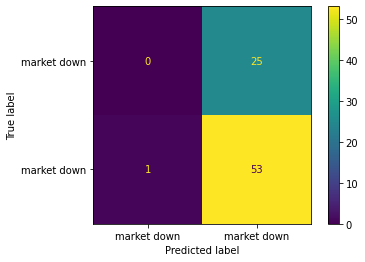

Confusion matrices, train & test data, model used - RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('standardscaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('logisticregression',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
            

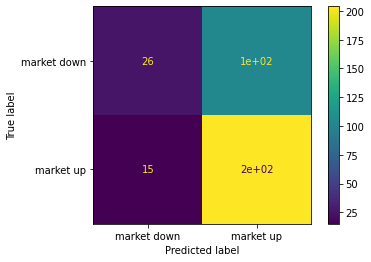

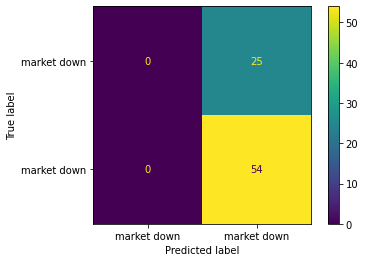

Confusion matrices, train & test data, model used - Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridgeclassifier',
                 RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True,
                                 fit_intercept=True, max_iter=None,
                                 normalize=False, random_state=22,
                                 solver='auto', tol=0.001))],
         verbose=False)





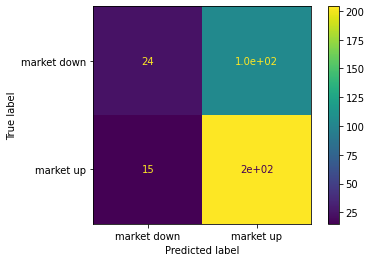

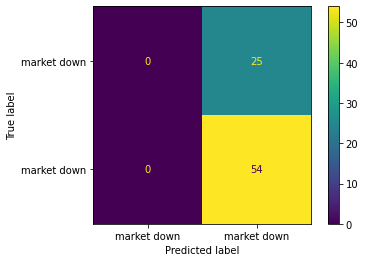

Confusion matrices, train & test data, model used - XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=22,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)





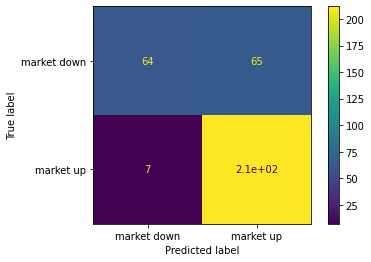

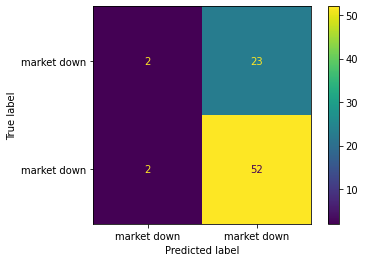

In [ ]:
# Plot Confusion Martices

models = [model_lr, model_rf, model_rs_lr, model_rc, model_XGBC]

for num, model in enumerate(models):
    print(f'Confusion matrices, train & test data, model used - {models[num]}')
    plot_confusion_matrix(model, X_train, y_train, display_labels=['market down', 'market up'])
    plot_confusion_matrix(model, X_test, y_test, display_labels=['market down', 'market down'])
    print('\n\n')
    plt.show();

ROC-AUC score for Logistic Regression: 0.5
ROC-AUC score for Random Forest Classsifier: 0.49074074074074076
ROC-AUC score for Ridge Classifier: 0.5
ROC-AUC score for XGBoost Classifier: 0.5214814814814814


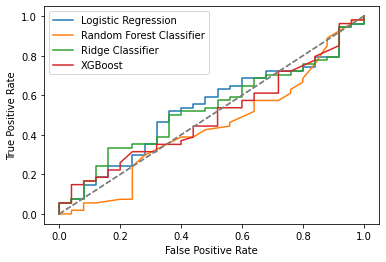

In [ ]:
# Plot ROC-AUC curvers for our models - their performance is no better than guessing

lr = plot_roc_curve(model_lr, X_test, y_test, label='Logistic Regression')
rf = plot_roc_curve(model_rf, X_test, y_test, ax=lr.ax_, label='Random Forest Classifier')
rc = plot_roc_curve(model_gs_rc, X_test, y_test, ax=lr.ax_, label='Ridge Classifier')
xgb = plot_roc_curve(model_XGBC, X_test, y_test, ax=lr.ax_, label='XGBoost')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

print(f'ROC-AUC score for Logistic Regression: {roc_auc_score(y_test, model_lr.predict(X_test))}')
print(f'ROC-AUC score for Random Forest Classsifier: {roc_auc_score(y_test, model_rf.predict(X_test))}')
print(f'ROC-AUC score for Ridge Classifier: {roc_auc_score(y_test, model_rc.predict(X_test))}')
print(f'ROC-AUC score for XGBoost Classifier: {roc_auc_score(y_test, model_XGBC.predict(X_test))}')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


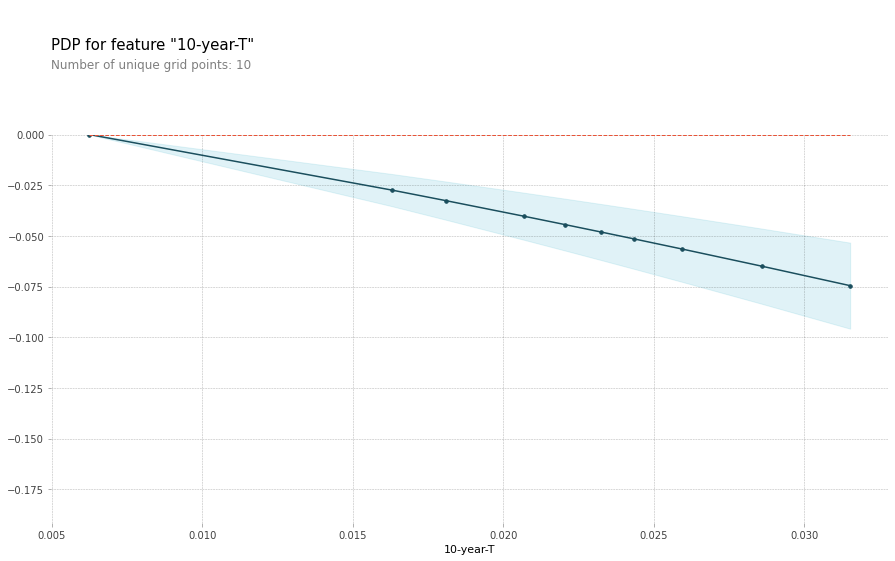

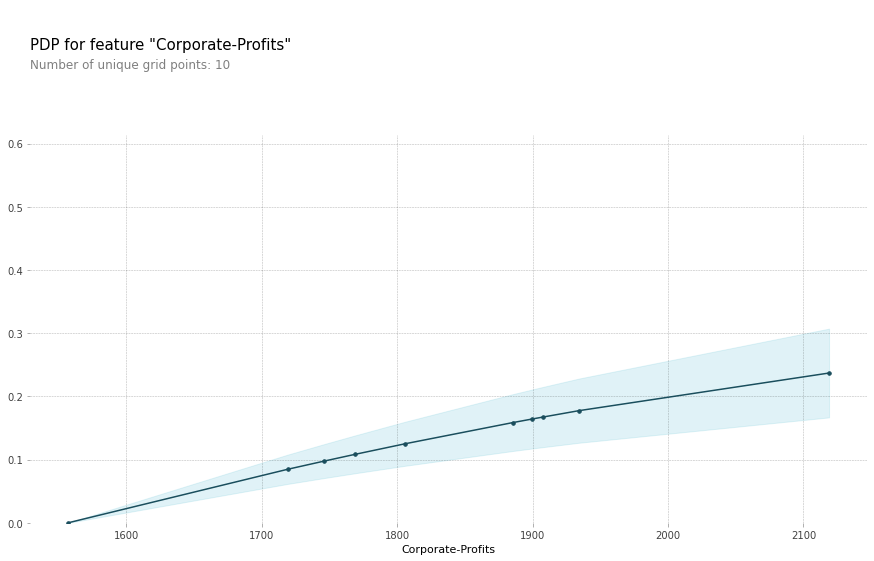

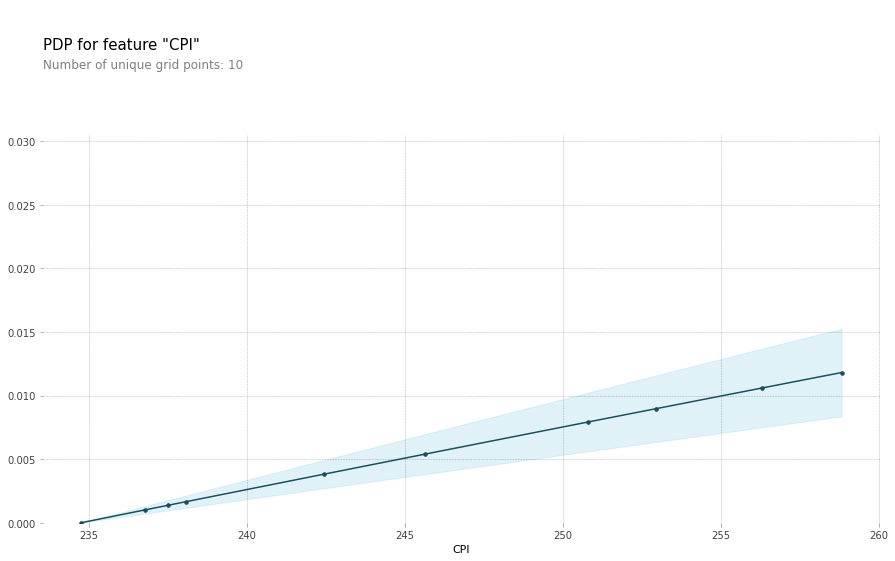

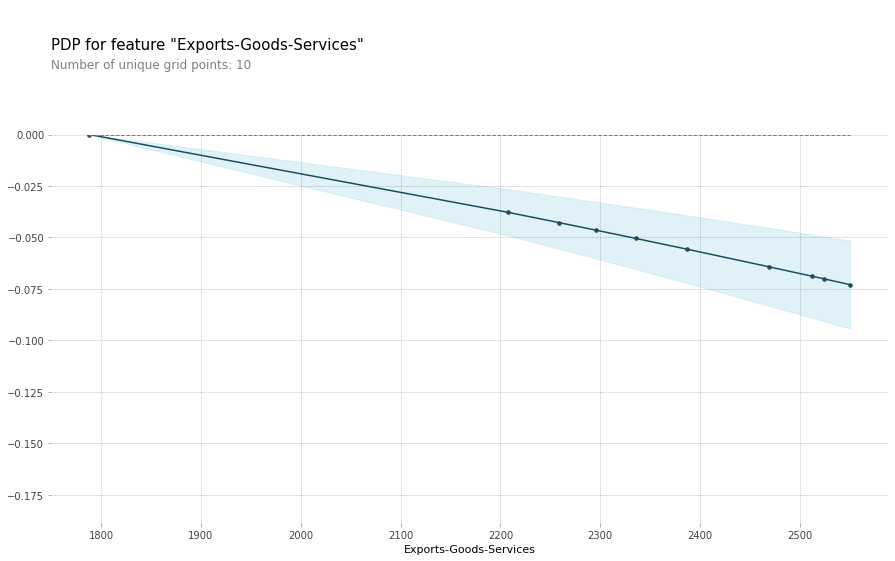

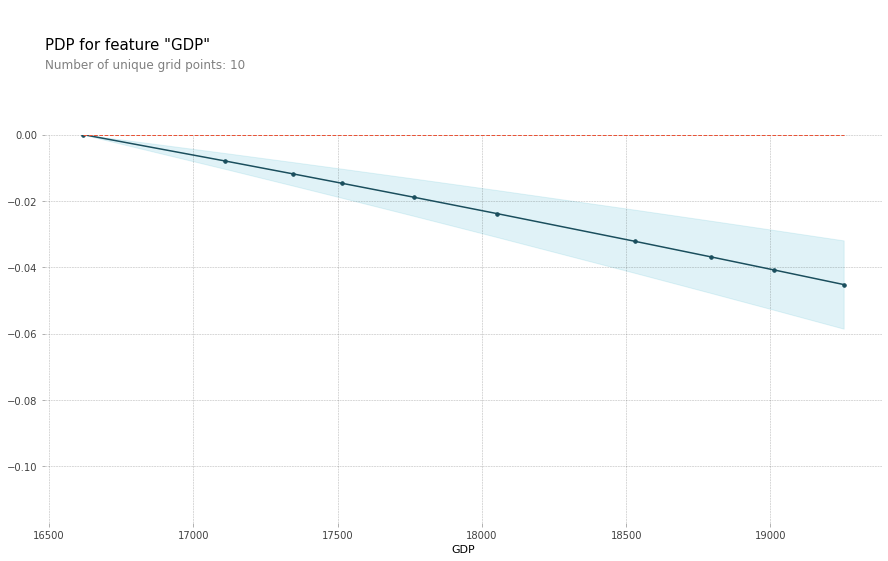

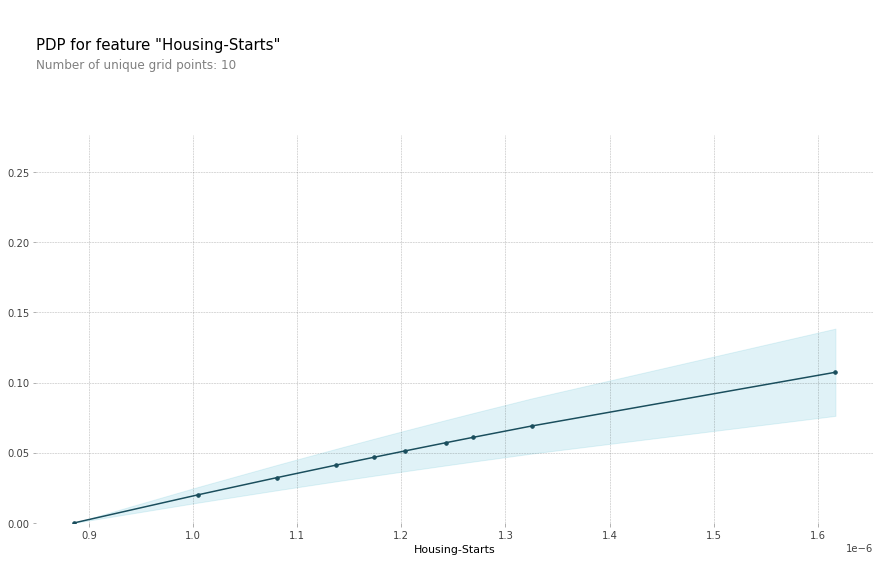

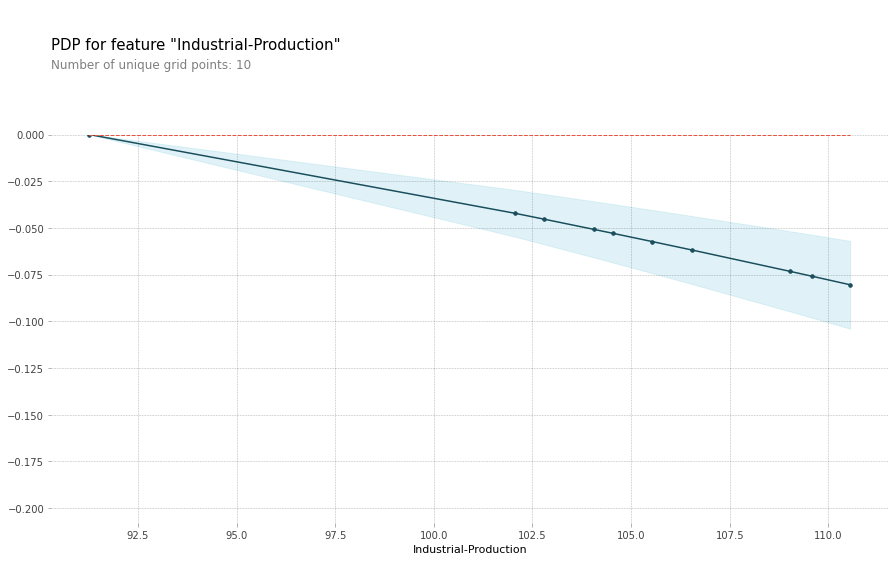

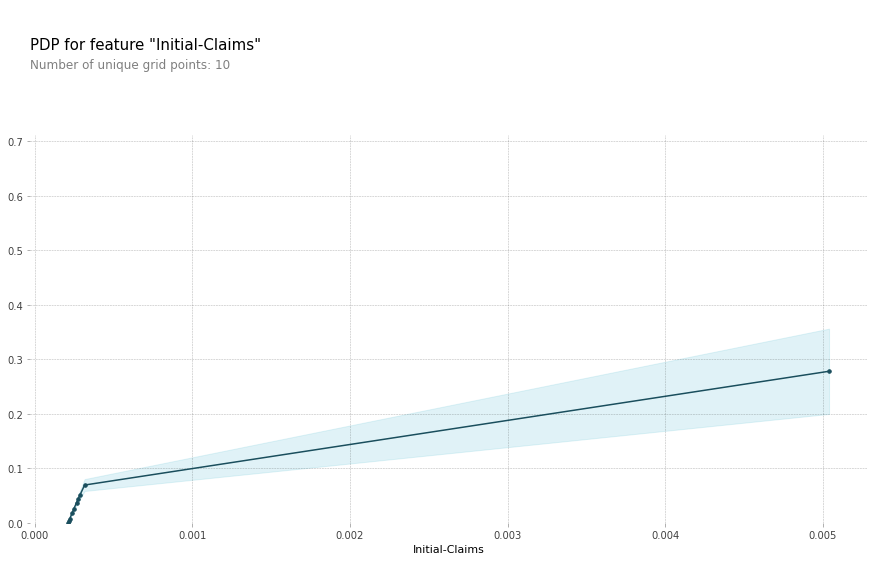

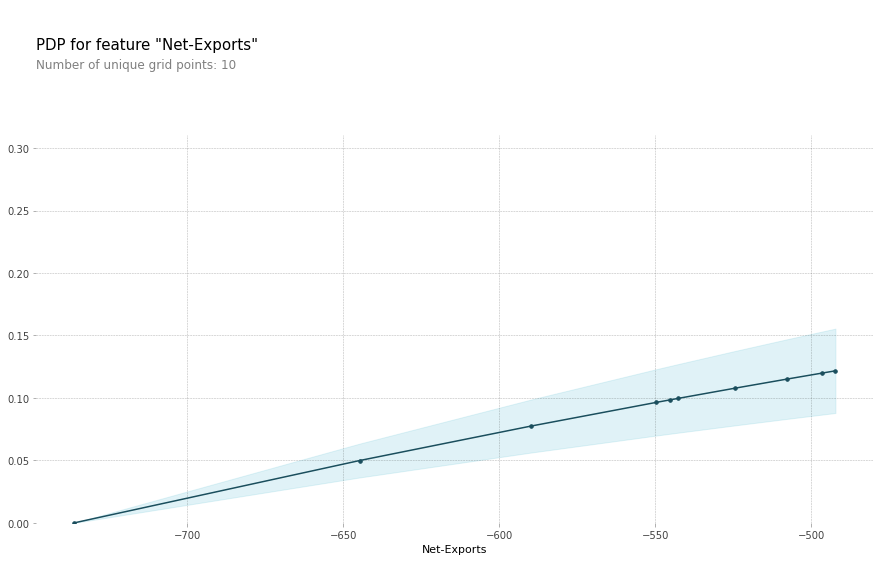

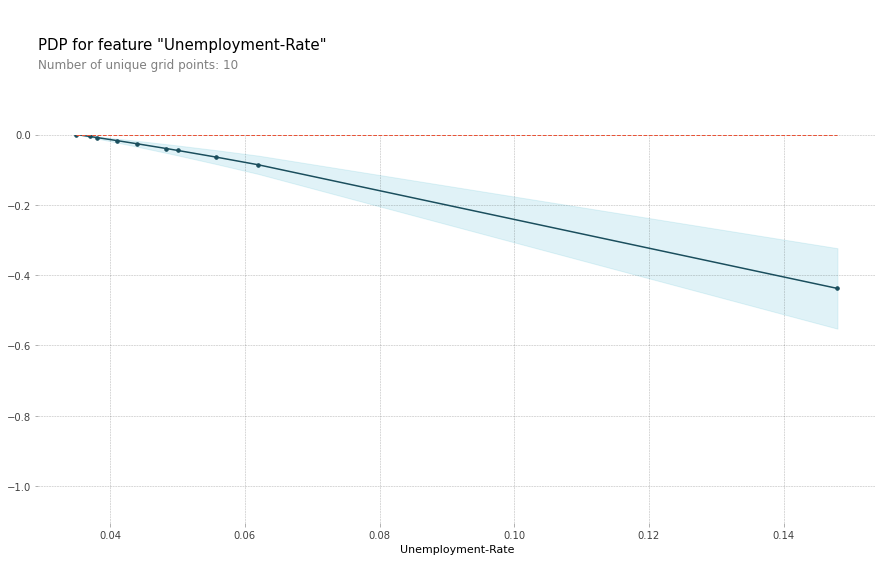

In [ ]:
# PDP isolate for corporate profits

feature = 'corp_profits'
features = list(X_test.columns)

for feature in features:
    isolate = pdp_isolate(
        model=model_lr,
        dataset=X_test,
        model_features=X_test.columns,
        feature=feature
    )
    pdp_plot(isolate, feature_name=feature);


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


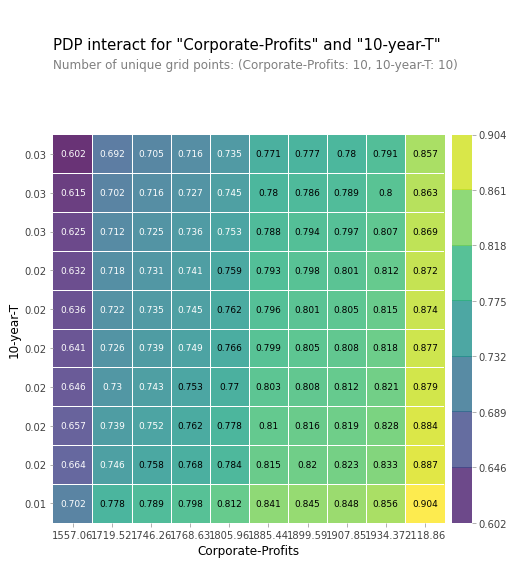

In [ ]:
features = ['Corporate-Profits', '10-year-T']

interact = pdp_interact(
    model=model_lr,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

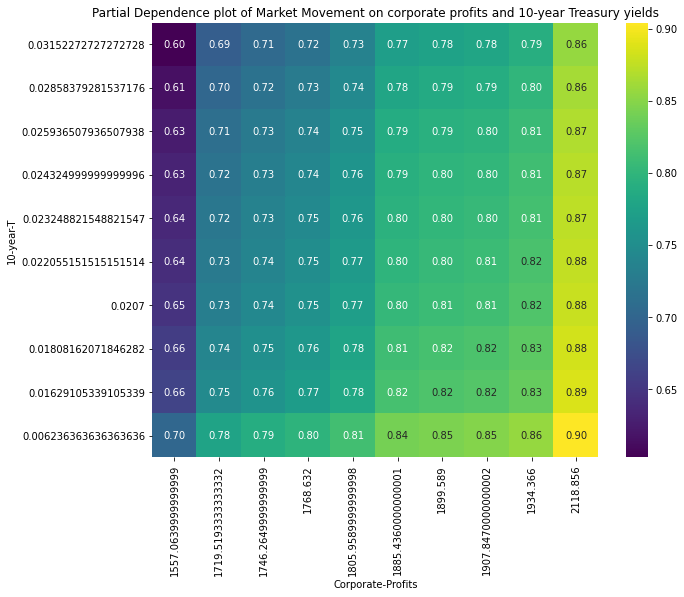

In [ ]:
pdp = interact.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1]
)[::-1]

plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence plot of Market Movement on corporate profits and 10-year Treasury yields');

In [ ]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

In [ ]:
# SHAP plot
# grab a single row

len(X_test)
row = X_test.iloc[[14]]


In [ ]:
model_lr.predict(row)

array([ True])

In [ ]:
import shap

explainer = shap.TreeExplainer(model_XGBC)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)